In [1]:
import os
# Prevent kernel from dying
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import string, time, math, random, sys, io, unicodedata

# For model testing
!pip install rouge
from rouge import Rouge
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
nltk.download('punkt')

# Importing Tensorflow and Keras

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence

# Constants

In [3]:
MAX_SEQUENCE_LENGTH = 48
BATCH_SIZE = 24
N_EPOCHS = 64

# Loading the Raw Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Reads the data
labeledPfd = pd.read_csv("/content/drive/MyDrive/LabeledPoetryFoundationPoems.csv")

# Filters the poems by category
def get_poems_by_category(category):
    data = []
    for poem, emotion in zip(labeledPfd["poem"], labeledPfd["emotion"]):
        if emotion == category:
            data.append(poem)
    return data


# Gets the poems in each category
poems = {
    "joy": get_poems_by_category("joy"),
    "trust": get_poems_by_category("trust"),
    "sadness": get_poems_by_category("sadness"),
    "anticipation": get_poems_by_category("anticipation"),
    "fear": get_poems_by_category("fear"),
    "anger": get_poems_by_category("anger"),
    "disgust": get_poems_by_category("disgust"),
    "surprise": get_poems_by_category("surprise")
}

# The Data Processor Class

In this cell, the data is processed into tokens that can be inputted into the model. Here we also create the input-output pair batches that will be used to train, validate, and evaluate, the model.

In [5]:

class Vocabulary:
    def __init__(self):
        punctuation = " .,<>'();?!:-\"\n"
        digits = "0123456789"
        self.valid_chars = string.ascii_letters + punctuation + digits

        # Encodes the position of each character in the vocabulary
        self.char2idx = {word: i for i, word in enumerate(self.valid_chars)}
        self.idx2char = np.array(list(self.valid_chars))

    def __len__(self):
        return len(self.valid_chars)

    def chars(self):
        return self.valid_chars
    
    def isValidChar(self, char):
        return char in self.valid_chars
    
    def charToId(self, char):
        return self.char2idx[char]

    def idToChar(self, id):
        return self.idx2char[id]

# Forms the vocabulary shared accross all models
vocab = Vocabulary()


class DataProcessor:
    def __init__(self, dataset, repeat=0):
        self.batch_size = BATCH_SIZE
        self.seq_len = MAX_SEQUENCE_LENGTH
        full_data = list(dataset)

        # We have to use 50 poems for testing
        # because we used this number for our
        # previous deliverable as well.
        self.test_set = full_data[:50]
        full_data = full_data[50:]

        # Cleans the poems in the test-set
        clean_test_set = []
        for poem in self.test_set:
            clean_test_set.append( "".join(self.clean_single_poem(poem)) )
        self.test_set = clean_test_set
        
        # Cleans the data by removing
        # punctuation from the dataset
        self.clean_data = self.data_cleaner(full_data)

        # Transforms the entire text into integers
        text_as_int = np.array([vocab.charToId(c) for c in self.clean_data])

        # Create training examples / targets
        char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
        sequences = char_dataset.batch(self.seq_len+1, drop_remainder=True)

        # Generates input-target pairs
        self.dataset = sequences.map(self.split_input_target)

        # Prints an example input-output pair
        print("Example Input-Target pair:")
        for input_example, target_example in self.dataset.take(1):
            print('  Input:  ', repr(''.join(vocab.idToChar(input_example.numpy()))))
            print('  Target: ', repr(''.join(vocab.idToChar(target_example.numpy()))))

        # Generates batches
        self.dataset = self.dataset.repeat(repeat + 1).batch(
            self.batch_size,
            drop_remainder=True
        )

        # Use 10% of the training dataset for validation
        tenPercent = math.ceil(len(dataset) * 0.1)
        self.val_inps = []
        self.val_tars = []
        val = self.dataset.take(tenPercent)
        self.dataset = self.dataset.skip(tenPercent)
        for val_inp, val_tar in val:
            self.val_inps.append(val_inp)
            self.val_tars.append(val_tar)

        # Print some useful info.
        print("Number of characters:", len(self.clean_data))
        print("Training batches: " + str(len(self.dataset)))



    def data_cleaner(self, poem_list):
        clean_data = []
        
        for poem in poem_list:
            clean_data += list(self.clean_single_poem(poem))
            
        return clean_data

    def clean_single_poem(self, poem):
        poem = self.unicodeToAscii(poem)
        clean_data = []

        # Adds the "poem start" symbol
        clean_data.append("<")

        for char in list(poem):
            # Converts tabs to spaces
            if char == "\t": char = " "

            prevChar = clean_data[len(clean_data) - 1]

            # Skips repeated "new line" characters and repeated spaces
            if vocab.isValidChar(char):
                if (char != "\n" and char != " ") or (char == "\n" and prevChar != "\n") or (char == " " and prevChar != " "):
                    clean_data.append(char)

        # Adds the "poem end" symbol
        clean_data.append(">")

        return clean_data

    def unicodeToAscii(self, s):
        # Turn a Unicode string to plain ASCII, thanks to
        # https://stackoverflow.com/a/518232/2809427
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
        )

    def split_input_target(self, chunk):
        input_text = chunk[:-1]
        target_text = chunk[1:]
        return input_text, target_text

# The Model Base Classes

In the next two blocks we define the `PoemModel` class and the `GeneratorModel` class. With these two classes we are able to reuse the same code for training multiple models and generating poems.

#### The Class for Training the Models

In [6]:
class PoemModel:
    def __init__(self, data, weights=None, print_summary=False, recurrent_units=256,
                 embedding_size=128, dropout_rate=0.2):
        """
        Creates a trainable model.
        ::data - An instance of the `DataProcessor` class.
        ::batch_size - The size of the batches used for training the model. 32
            by default.
        ::weights - When this class is used for prediction, a set of weights
            must be provided from another model which was used for training.
        """

        self.data = data
        self.history = None

        # Global Hyperparameters
        self.recurrent_units = recurrent_units
        self.embedding_size = embedding_size
        self.dropout_rate = dropout_rate
        self.n_epochs = N_EPOCHS
        self.optimizer = keras.optimizers.RMSprop()
        self.loss_function = lambda labels, logits: keras.losses.sparse_categorical_crossentropy(
            labels, logits, from_logits=True
        )

        # Model-Specific Hyperparameters
        self.batch_size = BATCH_SIZE if weights == None else 1
        self.weights = weights

        # Creates the model
        self.model = self.__createModel()
        if (print_summary): self.model.summary()


    def train(self):
        """
        Trains the model using the provided data under the GPU
        provided by Google Colab.
        """
        with tf.device('/device:GPU:0'):
            model_callbacks = [
                # Reduces the learning rate if the model is having trouble
                # learning the data. This is applied after two epochs with
                # no improvement to the model's loss.
                tf.keras.callbacks.ReduceLROnPlateau(patience=2),
                # If even after reducing the learning rate the model still does
                # not improve, after 5 epochs of non-improving loss, the model
                # halts the training process.
                tf.keras.callbacks.EarlyStopping(patience=4)
            ]

            self.history = self.model.fit(
                self.data.dataset,
                epochs=self.n_epochs,
                callbacks=model_callbacks,
                validation_data=(self.data.val_inps, self.data.val_tars),
                verbose=1
            )


    def plot_loss(self, name):
        if (self.history != None):
            plt.plot(self.history.history['loss'])
            plt.plot(self.history.history['val_loss'])
            plt.title('Metrics for ' + name + ' model')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()
        else:
            print("The model must be trained before the loss can be plotted.")


    def __createModel(self):
        """
        Creates an new sequential model with the specified
        hyperpearameters. If a set of weights (from anothe model)
        were provided, those weights are set for this model.
        """
        model = keras.models.Sequential([
            layers.Embedding(
                len(vocab),
                self.embedding_size,
                batch_input_shape=(self.batch_size, self.data.seq_len),
                name="EMBEDDING_layer"
            ),
            layers.Dense(len(vocab), activation="tanh", name="TANH_layer"),
            layers.GRU(
                self.recurrent_units,
                stateful=True,
                return_sequences=True,
                recurrent_initializer='glorot_uniform',
                name="GRU_layer"
            ),
            layers.Dropout(self.dropout_rate),
            layers.Dense(len(vocab), name="OUTPUT_layer")
        ])
        
        # If no wights were loaded into this model, we create a
        # new model from scratch. Otherwise we set the provided
        # wights into this model.
        if (self.weights == None):
            model.compile(loss=self.loss_function, optimizer=self.optimizer)
        else:
            model.set_weights(self.weights)
        
        # Returns the created model
        return model

#### The Class for Generating New Poems

In [7]:
class GeneratorModel:
    def __init__(self, trainedModel):
        self.trainedModel = trainedModel

        self.model = PoemModel(
            self.trainedModel.data,
            recurrent_units = self.trainedModel.recurrent_units,
            embedding_size = self.trainedModel.embedding_size,
            # Copies the trained weights into this model
            weights=trainedModel.model.get_weights(),
        )


    def generate(self, start_string, out_len, temperature=0.5):
        """
        Generates a new poem from the specified starting string.
        ::start_string - A seed string used for generating the new poem.
        ::out_len - The size (in characters) of the generated poem.
        ::temperature - The diversity of the generated text. If the number is
            low, the generated setences will look similar to the sentences it has
            seen before. If the number is high, the sentences will be more
            "original" (but may not look as perfect).
        """
        # Converting our start string to numbers (vectorizing)
        input_eval = [vocab.charToId(s) for s in start_string]
        input_eval = tf.expand_dims(input_eval, 0)

        # Empty string to store our results
        text_generated = []

        # Here batch size == 1
        # model.reset_states()
        for i in range(out_len):
            predictions = self.model.model(input_eval)
            # remove the batch dimension
            predictions = tf.squeeze(predictions, 0)

            # using a categorical distribution to predict
            # the character returned by the model
            predictions = predictions / temperature
            predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

            # Pass the predicted character as the next input to the model
            # along with the previous hidden state
            input_eval = tf.expand_dims([predicted_id], 0)

            predicted_char = vocab.idToChar(predicted_id)

            if predicted_char == ">":
                break
            else:
                text_generated.append(predicted_char)

        return (start_string + ''.join(text_generated))

# The Model Evaluator

In [8]:
def evaluate_model(model):
    rouge = Rouge()

    # cleans a peom
    def clean_poem(poem):
        return ["".join([char for char in word.lower() if vocab.isValidChar(char)])
                    for word in poem.split()]

    # list of poems with clean data as hypothesis for ROUGE
    rouge_hyp = [" ".join(clean_poem(poem)) for poem in model.model.data.test_set]
    rouge_refs = []

    # list of lists of poems with clean data as hypothesis for BLEU
    bleu_references = [clean_poem(poem) for poem in model.model.data.test_set]
    bleu_candidates = []

    chencherry = SmoothingFunction()

    for i in range(len(model.model.data.test_set)):
        first_chars = " ".join(list(rouge_hyp[i])[:MAX_SEQUENCE_LENGTH])
        gen_poem = model.generate(first_chars, 200, temperature=0.75)
        gen_poem = [word for word in nltk.word_tokenize(gen_poem)]

        # for rouge
        rouge_refs.append(" ".join(gen_poem))

        # for bleu
        bleu_candidates.append(gen_poem)

    rouge_scores = rouge.get_scores(rouge_hyp, rouge_refs, avg=True)
    print("ROUGE SCORE:", rouge_scores)

    bleu_score = corpus_bleu(bleu_references, bleu_candidates, smoothing_function=chencherry.method4)
    print("\nBLEU SCORE:", bleu_score)


# Generating the Datasets

In [9]:
print("VOCABULARY SIZE: " + str(len(vocab)))

print("\n\nJOY DATA =================================================")
joyData = DataProcessor(poems["joy"])

print("\n\nTRUST DATA ===============================================")
trustData = DataProcessor(poems["trust"])

print("\n\nSADNESS DATA =============================================")
sadnessData = DataProcessor(poems["sadness"])

print("\n\nANTICIPATION DATA ========================================")
anticipationData = DataProcessor(poems["anticipation"])

print("\n\nFEAR DATA ================================================")
fearData = DataProcessor(poems["fear"])

print("\n\nANGER DATA ===============================================")
angerData = DataProcessor(poems["anger"], repeat=1)

print("\n\nDISGUST DATA =============================================")
disgustData = DataProcessor(poems["disgust"], repeat=1)

VOCABULARY SIZE: 77


JOY DATA =================================================
Example Input-Target pair:
  Input:   '<\nMany nights while walking home \nafter work, fr'
  Target:  '\nMany nights while walking home \nafter work, fro'
Number of characters: 6284418
Training batches: 4914


TRUST DATA ===============================================
Example Input-Target pair:
  Input:   '<\nIm standing in field 17 of the long series, em'
  Target:  '\nIm standing in field 17 of the long series, emp'
Number of characters: 7017910
Training batches: 5542


SADNESS DATA =============================================
Example Input-Target pair:
  Input:   '<\nWatts bleeds\nleaving stained reminders\non dust'
  Target:  '\nWatts bleeds\nleaving stained reminders\non dusty'
Number of characters: 1947888
Training batches: 1478


ANTICIPATION DATA ========================================
Example Input-Target pair:
  Input:   '<\nI carry my spikes and step on the field an hou'
  Target:  '\nI carry 

# Defining the Models

## The Model for the Joy Category

In [10]:
joyModel = PoemModel(joyData, print_summary=True, recurrent_units=540, embedding_size=128)
print("\n")
joyModel.train()

# Because we trained the model using batch sizes specified in the
# BATCH_SIZE variable, using the original model will also require
# inputs of BATCH_SIZE in order to make a prediction. Because of that,
# we must create a new model whose batch_size is set to 1, and copy
# the weights from the original model into this prediction model.
joyGenerator = GeneratorModel(joyModel)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EMBEDDING_layer (Embedding)  (24, 48, 128)             9856      
_________________________________________________________________
TANH_layer (Dense)           (24, 48, 77)              9933      
_________________________________________________________________
GRU_layer (GRU)              (24, 48, 540)             1002780   
_________________________________________________________________
dropout (Dropout)            (24, 48, 540)             0         
_________________________________________________________________
OUTPUT_layer (Dense)         (24, 48, 77)              41657     
Total params: 1,064,226
Trainable params: 1,064,226
Non-trainable params: 0
_________________________________________________________________


Epoch 1/64
4914/4914 [==============================] - 44s 9ms/step - loss: 1.8786 - val_loss: 1.7406
Epoch 2

## The Model for the Trust Category

In [11]:
trustModel = PoemModel(trustData, print_summary=True, recurrent_units=540, embedding_size=128)
print("\n")
trustModel.train()

# Because we trained the model using batch sizes specified in the
# BATCH_SIZE variable, using the original model will also require
# inputs of BATCH_SIZE in order to make a prediction. Because of that,
# we must create a new model whose batch_size is set to 1, and copy
# the weights from the original model into this prediction model.
trustGenerator = GeneratorModel(trustModel)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EMBEDDING_layer (Embedding)  (24, 48, 128)             9856      
_________________________________________________________________
TANH_layer (Dense)           (24, 48, 77)              9933      
_________________________________________________________________
GRU_layer (GRU)              (24, 48, 540)             1002780   
_________________________________________________________________
dropout_2 (Dropout)          (24, 48, 540)             0         
_________________________________________________________________
OUTPUT_layer (Dense)         (24, 48, 77)              41657     
Total params: 1,064,226
Trainable params: 1,064,226
Non-trainable params: 0
_________________________________________________________________


Epoch 1/64
5542/5542 [==============================] - 49s 9ms/step - loss: 1.8868 - val_loss: 1.6957
Epoch

## The Model for the Sadness Category

In [12]:
sadnessModel = PoemModel(sadnessData, print_summary=True, recurrent_units=540, embedding_size=128)
print("\n")
sadnessModel.train()

# Because we trained the model using batch sizes specified in the
# BATCH_SIZE variable, using the original model will also require
# inputs of BATCH_SIZE in order to make a prediction. Because of that,
# we must create a new model whose batch_size is set to 1, and copy
# the weights from the original model into this prediction model.
sadnessGenerator = GeneratorModel(trustModel)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EMBEDDING_layer (Embedding)  (24, 48, 128)             9856      
_________________________________________________________________
TANH_layer (Dense)           (24, 48, 77)              9933      
_________________________________________________________________
GRU_layer (GRU)              (24, 48, 540)             1002780   
_________________________________________________________________
dropout_4 (Dropout)          (24, 48, 540)             0         
_________________________________________________________________
OUTPUT_layer (Dense)         (24, 48, 77)              41657     
Total params: 1,064,226
Trainable params: 1,064,226
Non-trainable params: 0
_________________________________________________________________


Epoch 1/64
1478/1478 [==============================] - 14s 9ms/step - loss: 2.1070 - val_loss: 1.9260
Epoch

## The Model for the Anticipation Category

In [13]:
anticipationModel = PoemModel(anticipationData, print_summary=True, recurrent_units=540, embedding_size=128)
print("\n")
anticipationModel.train()

# Because we trained the model using batch sizes specified in the
# BATCH_SIZE variable, using the original model will also require
# inputs of BATCH_SIZE in order to make a prediction. Because of that,
# we must create a new model whose batch_size is set to 1, and copy
# the weights from the original model into this prediction model.
anticipationGenerator = GeneratorModel(anticipationModel)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EMBEDDING_layer (Embedding)  (24, 48, 128)             9856      
_________________________________________________________________
TANH_layer (Dense)           (24, 48, 77)              9933      
_________________________________________________________________
GRU_layer (GRU)              (24, 48, 540)             1002780   
_________________________________________________________________
dropout_6 (Dropout)          (24, 48, 540)             0         
_________________________________________________________________
OUTPUT_layer (Dense)         (24, 48, 77)              41657     
Total params: 1,064,226
Trainable params: 1,064,226
Non-trainable params: 0
_________________________________________________________________


Epoch 1/64
1236/1236 [==============================] - 12s 10ms/step - loss: 2.1174 - val_loss: 1.7762
Epoc

## The Model for the Fear Category

In [14]:
fearModel = PoemModel(fearData, print_summary=True, recurrent_units=540, embedding_size=128)
print("\n")
fearModel.train()

# Because we trained the model using batch sizes specified in the
# BATCH_SIZE variable, using the original model will also require
# inputs of BATCH_SIZE in order to make a prediction. Because of that,
# we must create a new model whose batch_size is set to 1, and copy
# the weights from the original model into this prediction model.
fearGenerator = GeneratorModel(fearModel)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EMBEDDING_layer (Embedding)  (24, 48, 128)             9856      
_________________________________________________________________
TANH_layer (Dense)           (24, 48, 77)              9933      
_________________________________________________________________
GRU_layer (GRU)              (24, 48, 540)             1002780   
_________________________________________________________________
dropout_8 (Dropout)          (24, 48, 540)             0         
_________________________________________________________________
OUTPUT_layer (Dense)         (24, 48, 77)              41657     
Total params: 1,064,226
Trainable params: 1,064,226
Non-trainable params: 0
_________________________________________________________________


Epoch 1/64
1348/1348 [==============================] - 12s 9ms/step - loss: 2.1687 - val_loss: 2.0040
Epoch

## The Model for the Anger Category

In [15]:
angerModel = PoemModel(angerData, print_summary=True, recurrent_units=540,
                       embedding_size=128, dropout_rate=0.5)
print("\n")
angerModel.train()

# Because we trained the model using batch sizes specified in the
# BATCH_SIZE variable, using the original model will also require
# inputs of BATCH_SIZE in order to make a prediction. Because of that,
# we must create a new model whose batch_size is set to 1, and copy
# the weights from the original model into this prediction model.
angerGenerator = GeneratorModel(angerModel)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EMBEDDING_layer (Embedding)  (24, 48, 128)             9856      
_________________________________________________________________
TANH_layer (Dense)           (24, 48, 77)              9933      
_________________________________________________________________
GRU_layer (GRU)              (24, 48, 540)             1002780   
_________________________________________________________________
dropout_10 (Dropout)         (24, 48, 540)             0         
_________________________________________________________________
OUTPUT_layer (Dense)         (24, 48, 77)              41657     
Total params: 1,064,226
Trainable params: 1,064,226
Non-trainable params: 0
_________________________________________________________________


Epoch 1/64
172/172 [==============================] - 2s 12ms/step - loss: 2.7675 - val_loss: 2.3920
Epoch 

## The Model for the Disgust Category

In [16]:
disgustModel = PoemModel(disgustData, print_summary=True, recurrent_units=540,
                         embedding_size=128, dropout_rate=0.5)
print("\n")
disgustModel.train()

# Because we trained the model using batch sizes specified in the
# BATCH_SIZE variable, using the original model will also require
# inputs of BATCH_SIZE in order to make a prediction. Because of that,
# we must create a new model whose batch_size is set to 1, and copy
# the weights from the original model into this prediction model.
disgustGenerator = GeneratorModel(disgustModel)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EMBEDDING_layer (Embedding)  (24, 48, 128)             9856      
_________________________________________________________________
TANH_layer (Dense)           (24, 48, 77)              9933      
_________________________________________________________________
GRU_layer (GRU)              (24, 48, 540)             1002780   
_________________________________________________________________
dropout_12 (Dropout)         (24, 48, 540)             0         
_________________________________________________________________
OUTPUT_layer (Dense)         (24, 48, 77)              41657     
Total params: 1,064,226
Trainable params: 1,064,226
Non-trainable params: 0
_________________________________________________________________


Epoch 1/64
54/54 [==============================] - 1s 18ms/step - loss: 3.2233 - val_loss: 2.7376
Epoch 2/

# Evalutating the Models

JOY EVALUTATION =================================================
ROUGE SCORE: {'rouge-1': {'f': 0.12708282213811473, 'p': 0.10010743766329946, 'r': 0.20815215317588864}, 'rouge-2': {'f': 0.007287393039041722, 'p': 0.005454527163075746, 'r': 0.013198731118924924}, 'rouge-l': {'f': 0.09921037948496304, 'p': 0.07452135412108399, 'r': 0.1712724632905951}}

BLEU SCORE: 0.27554434947708756

Example Poem: <Love, while she grew a room grief lest one, that I cant be
Of rushing Sunday was the closed towing pleas




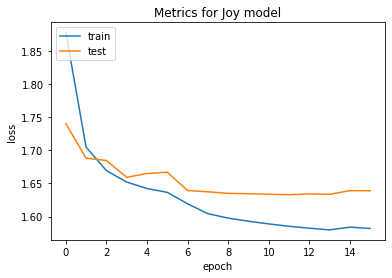



TRUST EVALUTATION ===========================================
ROUGE SCORE: {'rouge-1': {'f': 0.1368739905063895, 'p': 0.10930026549413652, 'r': 0.23193377085606381}, 'rouge-2': {'f': 0.007965243918648399, 'p': 0.006063790184158162, 'r': 0.015262470647267818}, 'rouge-l': {'f': 0.1087243221812654, 'p': 0.08243367357734062, 'r': 0.1950938327587952}}

BLEU SCORE: 0.2712913127520964

Example Poem: <Feels where is night before a book in the apparent you hear it. This pladed back,
 
 
r your steel, the 




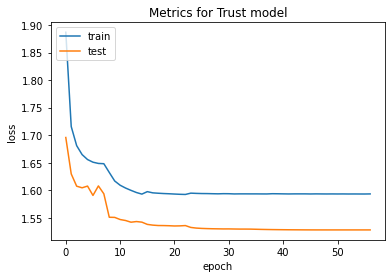



SADNESS EVALUTATION =========================================
ROUGE SCORE: {'rouge-1': {'f': 0.13398344746581434, 'p': 0.10813840273862219, 'r': 0.22510527939979805}, 'rouge-2': {'f': 0.009021907478718061, 'p': 0.007506910200246261, 'r': 0.015822172888703676}, 'rouge-l': {'f': 0.10603304745676909, 'p': 0.0810606100988538, 'r': 0.18970075332255676}}

BLEU SCORE: 0.27328983574510163

Example Poem: <Tears it is closers, the private sea. A painting staggered there,
shadows at the end, 
and the sound of 




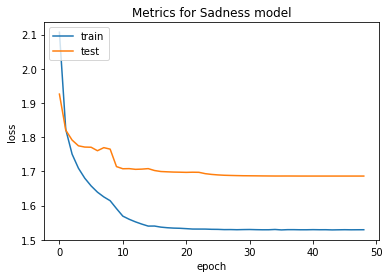



ANTICIPATION EVALUTATION ====================================
ROUGE SCORE: {'rouge-1': {'f': 0.12786614505927427, 'p': 0.10544624735814363, 'r': 0.2165056848309818}, 'rouge-2': {'f': 0.008817178717733899, 'p': 0.006843298207447817, 'r': 0.01766722648573197}, 'rouge-l': {'f': 0.10162986373147839, 'p': 0.07769553088990858, 'r': 0.1849200629165228}}

BLEU SCORE: 0.28316564090825247

Example Poem: <Hope from the sea of the real path bottle of the stone free
Silver ball pocket up and unrevery to look a




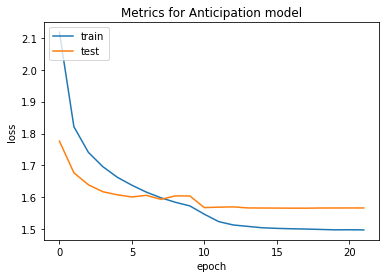



FEAR EVALUTATION ============================================
ROUGE SCORE: {'rouge-1': {'f': 0.13351208664665484, 'p': 0.10894166635059405, 'r': 0.20618776166826538}, 'rouge-2': {'f': 0.009169675075354114, 'p': 0.007112089448907892, 'r': 0.015862163675624822}, 'rouge-l': {'f': 0.1072314248194452, 'p': 0.08279112008064933, 'r': 0.17727181289737676}}

BLEU SCORE: 0.2770236146273263

Example Poem: <Fear Charcaso whe were garden has been cigarettes moments.
 
I was around all these great tongue everyth




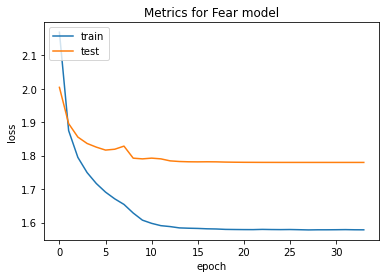



ANGER EVALUTATION ===========================================
ROUGE SCORE: {'rouge-1': {'f': 0.11382072179238917, 'p': 0.11762036084180975, 'r': 0.15056587621100895}, 'rouge-2': {'f': 0.005529976046759111, 'p': 0.005156710215141729, 'r': 0.007622264567842585}, 'rouge-l': {'f': 0.09556284563855526, 'p': 0.08975242918561215, 'r': 0.1338607292327017}}

BLEU SCORE: 0.2823429312052886

Example Poem: <Ragel peace, rise up by hates my fecold. Well, will bring it held blind of the heast lived bereft, heati




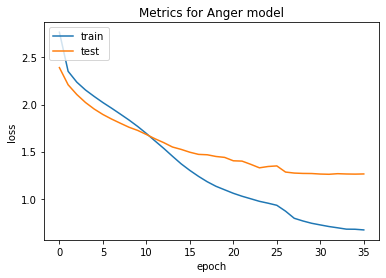



DISGUST EVALUTATION =========================================
ROUGE SCORE: {'rouge-1': {'f': 0.10344364024044245, 'p': 0.10704336190426349, 'r': 0.13766669166104525}, 'rouge-2': {'f': 0.005072218325367217, 'p': 0.004513571389413123, 'r': 0.007094657932399527}, 'rouge-l': {'f': 0.08653077250225046, 'p': 0.08451418232129633, 'r': 0.12402477222019101}}

BLEU SCORE: 0.2900818935223935

Example Poem: <Guts a better and smareeracy muff gish that fart fires the spares of you,
 Billows aball wero kink was a




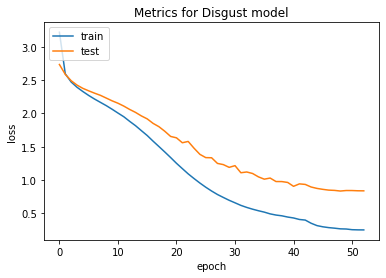

In [17]:
# Sometimes the ROUGE scoring needs a larger
# recursion depth. We reset the recursive
# limit to be higher. In case the limit is
# too low for the current test.
defaultRecursionDepth = sys.getrecursionlimit()
sys.setrecursionlimit(defaultRecursionDepth * 100)

print("JOY EVALUTATION =================================================")
evaluate_model(joyGenerator)
print("\nExample Poem: " + joyGenerator.generate("<Love", 100, temperature=0.8))
print("\n")
joyModel.plot_loss("Joy")

print("\n\nTRUST EVALUTATION ===========================================")
evaluate_model(trustGenerator)
print("\nExample Poem: " + trustGenerator.generate("<Feel", 100, temperature=0.8))
print("\n")
trustModel.plot_loss("Trust")

print("\n\nSADNESS EVALUTATION =========================================")
evaluate_model(sadnessGenerator)
print("\nExample Poem: " + sadnessGenerator.generate("<Tear", 100, temperature=0.8))
print("\n")
sadnessModel.plot_loss("Sadness")

print("\n\nANTICIPATION EVALUTATION ====================================")
evaluate_model(anticipationGenerator)
print("\nExample Poem: " + anticipationGenerator.generate("<Hope", 100, temperature=0.8))
print("\n")
anticipationModel.plot_loss("Anticipation")

print("\n\nFEAR EVALUTATION ============================================")
evaluate_model(fearGenerator)
print("\nExample Poem: " + fearGenerator.generate("<Fear", 100, temperature=0.8))
print("\n")
fearModel.plot_loss("Fear")

print("\n\nANGER EVALUTATION ===========================================")
evaluate_model(angerGenerator)
print("\nExample Poem: " + angerGenerator.generate("<Rage", 100, temperature=0.8))
print("\n")
angerModel.plot_loss("Anger")

print("\n\nDISGUST EVALUTATION =========================================")
evaluate_model(disgustGenerator)
print("\nExample Poem: " + disgustGenerator.generate("<Guts", 100, temperature=0.8))
print("\n")
disgustModel.plot_loss("Disgust")

# Reset the recursion depth after we are done
# testing, so that other parts of the program
# do not take advantage of it.
sys.setrecursionlimit(defaultRecursionDepth)

# Generating New Poems

In [96]:
def generate_poem_MIL(cat, seed, outlen, creativeness):
    cat = cat.lower()
    model = None

    # Only accepts arguments between 0-1 for the creativeness
    creativeness = creativeness if creativeness > 0 else 0
    creativeness = creativeness if creativeness < 1 else 1
    # The "creativeness" parameter accepts a float between 0-1,
    # but we linearly map that number to be between 0.4 and 1,
    # since a temperature outside that range tends to yield
    # nonsensical sequences.
    creativeness = (0.6 * creativeness) + 0.4

    # Chooses the apropriate model based
    # on the provided category
    if cat == "joy":
        model = joyGenerator
    elif cat == "trust":
        model = trustGenerator
    elif cat == "sadness":
        model = sadnessGenerator
    elif cat == "anticipation":
        model = anticipationGenerator
    elif cat == "fear":
        model = fearGenerator
    elif cat == "anger":
        model = angerGenerator
    elif cat == "disgust":
        model = disgustGenerator
    else:
        # The user must provide a valid category
        # in order to generate any poems
        return None
    
    return model.generate(seed, outlen, temperature=creativeness)

In [98]:
def MIL():
    emotion = ""
    seed = ""
    outlen = 0
    creativeness = 0

    # Gets the seed
    while True:
        answer = input(":: Provied a start for the poem: \n>> ")

        if len(answer) > 0:
            seed = answer
            break
        else:
            print("\n:: Please provide at leat one character for the poem's start.")

    # Get the generated length
    while True:
        answer = input("\n\n:: How many characters long should the poem be? \n>> ")

        try:
            outlen = int(answer)
            break
        except ValueError:
            print("\n:: Please provide a valid integer.")

    # Get the creativeness
    while True:
        answer = input("\n\n:: How creative should the model be? (0-1)\n>> ")

        try:
            if float(answer) >= 0 and float(answer) <= 1:
                creativeness = float(answer)
                break
            else:
                print(":: Please provide a valid float between 0 and 1.")
        except ValueError:
            print(":: Please provide a valid float between 0 and 1.")

    # Get the emotion
    def emo():
        cat = None
        while True:
            answer = input("\n\n:: Please select an emotion from the following:\n   "+
                        "[joy, trust, sadness, anticipation, fear, anger, disgust]\n>> ")
            
            if answer in ["joy","trust","sadness","anticipation","fear","anger","disgust"]:
                cat = answer
                break
            else:
                print("\n:: Please provide a valid emotion.")
        return cat

    emotion = emo()

    def p():
        print("\n\n\n================\n" +
            str(generate_poem_MIL(emotion, seed, outlen, creativeness)) +
            "\n================\n")
    p()

    # Generate poems
    while True:
        option = input("\n\n:: Please select an action: "+
              "\na) Choose another emotion\nb) Generate new poem\nc) Stop\n>> ")
        
        if option in ["a", "b", "c"]:
            if option == "a":
                emotion = emo()
                p()
            elif option == "b":
                p()
            elif option == "c":
                break
        else:
            print("please select a valid option")

In [ ]:
MIL()